# Behavioral data: Data wrangling & QA

Natalia Vélez, August 2021

This notebook was used to clean up the raw behavioral data and to ensure that the data are complete.

In [1]:
%matplotlib inline

import glob, json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('white')

# helper function
def str_extract(pattern, s): return re.search(pattern, s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))

Find behavioral files for the teaching task:

In [2]:
teaching_files = glob.glob('../../behavioral/*.json')
teaching_files = [f for f in teaching_files if 'run-practice' not in f]
teaching_files.sort()

print('%i files found' % len(teaching_files))
print(*teaching_files[:20], sep='\n')
print('...')

299 files found
../../behavioral/sub-01_task-teaching_run-01_behavioral_1628798255.json
../../behavioral/sub-01_task-teaching_run-02_behavioral_1628798680.json
../../behavioral/sub-01_task-teaching_run-03_behavioral_1628799162.json
../../behavioral/sub-01_task-teaching_run-04_behavioral_1628800012.json
../../behavioral/sub-01_task-teaching_run-05_behavioral_1628800423.json
../../behavioral/sub-01_task-teaching_run-06_behavioral_1628800796.json
../../behavioral/sub-01_task-teaching_run-07_behavioral_1628801177.json
../../behavioral/sub-01_task-teaching_run-08_behavioral_1628801584.json
../../behavioral/sub-01_task-teaching_run-09_behavioral_1628802076.json
../../behavioral/sub-01_task-teaching_run-10_behavioral_1628802432.json
../../behavioral/sub-02_task-teaching_run-01_behavioral_1628805799.json
../../behavioral/sub-02_task-teaching_run-02_behavioral_1628806247.json
../../behavioral/sub-02_task-teaching_run-03_behavioral_1628806617.json
../../behavioral/sub-02_task-teaching_run-04_beh

Find behavioral files for the Theory of Mind localizer:

In [3]:
tomloc_files = glob.glob('../../tomloc/*.mat')
tomloc_files.sort()

print('%i files found' % len(tomloc_files))
print(*tomloc_files[:20], sep='\n')
print('...')

59 files found
../../tomloc/teaching_01.tom_localizer.1.mat
../../tomloc/teaching_01.tom_localizer.2.mat
../../tomloc/teaching_02.tom_localizer.1.mat
../../tomloc/teaching_02.tom_localizer.2.mat
../../tomloc/teaching_03.tom_localizer.1.mat
../../tomloc/teaching_04.tom_localizer.1.mat
../../tomloc/teaching_04.tom_localizer.2.mat
../../tomloc/teaching_05.tom_localizer.1.mat
../../tomloc/teaching_05.tom_localizer.2.mat
../../tomloc/teaching_06.tom_localizer.1.mat
../../tomloc/teaching_06.tom_localizer.2.mat
../../tomloc/teaching_07.tom_localizer.1.mat
../../tomloc/teaching_07.tom_localizer.2.mat
../../tomloc/teaching_08.tom_localizer.1.mat
../../tomloc/teaching_08.tom_localizer.2.mat
../../tomloc/teaching_09.tom_localizer.1.mat
../../tomloc/teaching_09.tom_localizer.2.mat
../../tomloc/teaching_10.tom_localizer.1.mat
../../tomloc/teaching_10.tom_localizer.2.mat
../../tomloc/teaching_11.tom_localizer.1.mat
...


Load excluded participants:

In [4]:
excluded = np.loadtxt('../1_preprocessing/outputs/excluded_participants.txt', dtype=str)
print(excluded)

['sub-03' 'sub-17']


## Teaching task

How many behavioral files per participant?

In [5]:
teaching_counts = pd.DataFrame({'teaching': teaching_files})
teaching_counts['subject'] = teaching_counts.teaching.str.extract('(sub-[0-9]{2})')
teaching_counts = teaching_counts[~teaching_counts.subject.isin(excluded)]
teaching_counts = teaching_counts.groupby('subject')['teaching'].agg('count').reset_index()
teaching_counts

,subject,teaching
0,sub-01,10
1,sub-02,10
2,sub-04,10
3,sub-05,10
4,sub-06,10
5,sub-07,10
6,sub-08,10
7,sub-09,10
8,sub-10,10
9,sub-11,10


Helper function: Get starting points

In [6]:
def closest_start(point):
    corners = np.array([[0,0], [0,5], [5,0], [5,5]])    
    dists = np.sum((point - corners)**2, axis=1)
    
    closest_idx = np.argmin(dists)
    return corners[closest_idx].tolist()


def trial_start(choose_data):
    '''
    gets participant's first movement in a block to infer
    their starting point
    '''
    
    # get first movement
    df = choose_data.copy()
    df = df[df['movements'].apply(len) > 0] # discard trials where the participant didn't move
    df = df.groupby('problem').first().reset_index() # first trial
    df['first_movement'] = df['movements'].apply(lambda x: x[0][0])
    
    # find anchor point closest to it
    df['start'] = df['first_movement'].apply(closest_start)
    df = df[['problem', 'first_movement', 'start']]
    return df

Data wrangling:

In [7]:
run_list = []

for f in teaching_files:

    # load file
    sub = int_extract('(?<=sub-)([0-9]+)', f)
    run = int_extract('(?<=run-)([0-9]+)', f)
    run_data = pd.read_json(f)
    run_data['subject'] = sub
    run_data['run'] = run

    # choose trials
    run_choose = run_data[run_data.type == 'choose'] # filter data
    run_starts = trial_start(run_choose) # find start points
    run_choose = run_choose.merge(run_starts) # combine
    run_choose = run_choose[['subject', 'run', 'problem_idx', 'ex_idx', 'first_movement', 'start', 'ons', 'problem', 'order', 'example']]
    
    # first starting points

    # rate trials
    run_rate = run_data[run_data.type == 'rate']
    run_rate = run_rate[['subject', 'run', 'problem_idx', 'ex_idx', 'rating']]

    # merge
    clean_data = run_choose.merge(run_rate)
    clean_data = clean_data.rename(columns={'ons': 'onset'})
    run_list.append(clean_data)
    
# concatenate and clean up data
teaching_data = pd.concat(run_list)
teaching_data = teaching_data[~teaching_data.subject.isin(excluded)]
teaching_data = teaching_data.rename(columns={'problem_idx': 'block_idx'})
teaching_data[['block_idx', 'ex_idx', 'problem']] = teaching_data[['block_idx', 'ex_idx', 'problem']].astype(np.int)

print(teaching_data.shape)
teaching_data.head()

(3588, 11)


,subject,run,block_idx,ex_idx,first_movement,start,onset,problem,order,example,rating
0,1,1,0,0,"[0, 1]","[0, 0]",30.00,22,"[C, B, D, A]","[1, 2]",1.0
1,1,1,0,1,"[0, 1]","[0, 0]",45.35,22,"[C, B, D, A]","[4, 3]",2.0
2,1,1,0,2,"[0, 1]","[0, 0]",59.35,22,"[C, B, D, A]",None,2.0
3,1,1,1,0,"[0, 4]","[0, 5]",104.05,18,"[D, B, C, A]","[0, 3]",0.0
4,1,1,1,1,"[0, 4]","[0, 5]",118.45,18,"[D, B, C, A]","[5, 2]",NaN


Sanity check: Start points are properly counterbalanced?

(Note: The only participant had that had fewer than 10 problems w/ each start point only completed 9 runs of the teaching task)

In [8]:
start_summ = teaching_data.copy()
start_summ['start_label'] = start_summ['start'].astype(str)
start_summ = start_summ.groupby(['subject', 'start_label'])['problem'].nunique().reset_index()
start_summ[start_summ['problem'] != 10] # any deviations

,subject,start_label,problem
8,3,"[0, 0]",9
9,3,"[0, 5]",9
10,3,"[5, 0]",9
11,3,"[5, 5]",9


Number of successful trials:

In [9]:
teaching_summ = teaching_data.groupby('subject')[['example', 'rating']].agg('count').reset_index()

# merge with number of runs
teaching_summ['subject'] = teaching_summ['subject'].apply(lambda s: 'sub-%02d' % s)
teaching_summ = teaching_summ.merge(teaching_counts)
teaching_summ = teaching_summ.rename(columns={'teaching': 'n_runs'})

teaching_summ['pct_example'] = teaching_summ.example/(12*teaching_summ.n_runs)*100
teaching_summ['pct_rating'] = teaching_summ.rating/(12*teaching_summ.n_runs)*100
teaching_summ

,subject,example,rating,n_runs,pct_example,pct_rating
0,sub-01,108,112,10,90.000000,93.333333
1,sub-02,114,116,10,95.000000,96.666667
2,sub-04,113,114,10,94.166667,95.000000
3,sub-05,114,120,10,95.000000,100.000000
4,sub-06,115,119,10,95.833333,99.166667
5,sub-07,118,118,10,98.333333,98.333333
6,sub-08,119,116,10,99.166667,96.666667
7,sub-09,116,120,10,96.666667,100.000000
8,sub-10,112,118,10,93.333333,98.333333
9,sub-11,100,116,10,83.333333,96.666667


In [10]:
teaching_summ[['pct_example', 'pct_rating']].agg(['min', 'max', 'mean'])

,pct_example,pct_rating
min,83.333333,79.166667
max,100.000000,100.000000
mean,95.625000,97.113095


[Text(0.5, 0, '% examples provided (out of max)')]

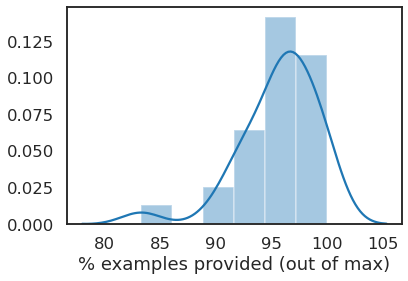

In [11]:
ax = sns.distplot(teaching_summ.pct_example)
ax.set(xlabel='% examples provided (out of max)')

[Text(0.5, 0, '% ratings provided (out of max)')]

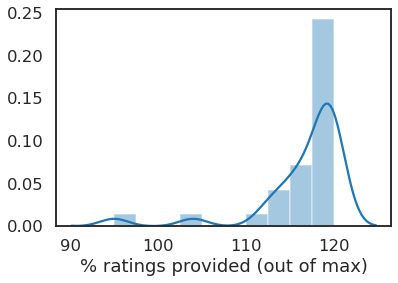

In [12]:
ax = sns.distplot(teaching_summ.rating)
ax.set(xlabel='% ratings provided (out of max)')

Save outputs to file

In [13]:
teaching_data.to_csv('outputs/teaching_behavior.csv', index=False)
teaching_summ.to_csv('outputs/teaching_compliance.csv', index=False)

## Theory of Mind localizer

How many behavioral files per participant?

In [14]:
tomloc_counts = pd.DataFrame({'tomloc': tomloc_files})
tomloc_counts['subject'] = tomloc_counts.tomloc.str.extract('(teaching_[0-9]{2})')
tomloc_counts['subject'] = tomloc_counts.subject.str.replace('teaching_', 'sub-')
tomloc_counts = tomloc_counts[~tomloc_counts.subject.isin(excluded)]
tomloc_counts = tomloc_counts.groupby('subject')['tomloc'].agg('count')
tomloc_counts

subject
sub-01    2
sub-02    2
sub-04    2
sub-05    2
sub-06    2
sub-07    2
sub-08    2
sub-09    2
sub-10    2
sub-11    2
sub-12    2
sub-13    2
sub-14    2
sub-15    2
sub-16    2
sub-18    2
sub-19    2
sub-20    2
sub-21    2
sub-22    2
sub-23    2
sub-24    2
sub-25    2
sub-26    2
sub-27    2
sub-28    2
sub-29    2
sub-30    2
Name: tomloc, dtype: int64